In [4]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors

import starry
import astropy.units as u
import jwst as jwst
import pickle as pkl

from numba import jit

from volcano.utils import *

np.random.seed(42)
starry.config.lazy = False

In [5]:
%matplotlib inline
%run notebook_setup.py

In [6]:
#  Stellar parameters
params_s = dict(
    r= 0.936* u.Rsun,  #  radius in R_sun
    m=0.96 * u.Msun,  # mass in M_sun
    prot=42.2 * u.d,  # rotational period in days
    u=[0.40, 0.25],  # limb darkening coefficients
    T=5165 * u.K,
    d=12.38 * u.pc,
)

# Planet parameters
params_p = dict(
    inc=83.3 * u.deg,  # inclination in degrees
    r=(1.91 * u.Rearth).to(u.Rsun),  #  radius in R_sun
    m=(8.08 * u.Mearth).to(u.Msun),  #  mass in M_sun
    porb=0.736539 * u.d,  # orbital period in days
    prot=0.736539 * u.d,  # rotational period in days
    t0=0.0,  # reference time in days (when it transits A)
    e=0.05,
)

# Create semi-realistic temperature map of the planet

In [7]:
from scipy.optimize import brent

@jit
def cost_fn(T, intensity):
    Blam = np.pi * planck(T, lam)
    return np.sum((Blam - intensity) ** 2)


def starry_intensity_to_teff(intensity):
    if not np.any(np.isnan(intensity)):
        return brent(
            cost_fn, args=(intensity,), brack=(10, 5000), tol=1e-04, maxiter=400
        )
    else:
        return np.nan


@jit
def planck(temp, wav):
    h = 6.62607e-34  # Planck constant (J * s)
    c = 2.998e8  # Speed of light (m / s)
    k = 1.3807e-23  # Boltzmann constant (J / K)
    wav = wav * 1e-6

    # Returns B_lambda [W/m^2/um/sr]
    return (
        1e-6
        * (2.0 * h * c ** 2)
        / (wav ** 5)
        / (np.exp(h * c / (wav * k * temp)) - 1.0)
    )

Monochromatic luminosity:
$$
L_\lambda=\pi(4\pi R^2)B_\lambda
$$ 

In [8]:
Nlam = 1000
lammin = 3.0
lammax = 7.0
lam = np.linspace(lammin, lammax, Nlam)

map_planet = starry.Map(ydeg=25, nw=Nlam)

# Set background temperature to 1000K
L = (
    np.pi * (4 * np.pi) * planck(1000, lam)
)  # Integrate Planck function over solid angle and area
map_planet.amp = (
    L / 4
)  #  Factor of 4 is here because in Starry the luminosity of a featureless map is 4.

background_int = map_planet.intensity()[0]

#  Sanity check
assert np.allclose(background_int, np.pi * planck(1000, lam))

def spot_sigma(ang_dim):
    spot_ang_dim = ang_dim * np.pi / 180
    return 1 - np.cos(spot_ang_dim / 2)

# Put one large spot on dayside to simulate insolation, set temperature of dayside spot to 1400K
dayside_int = np.pi * planck(1200, lam)

map_planet.add_spot(
    intensity=(dayside_int - background_int) / background_int / map_planet.amp,
    sigma=spot_sigma(80),
    lat=0.0,
    lon=180.0,
    relative=True,
)

# Place a high temperature spot on the dayside
spot_int = np.pi * planck(3200, lam)
spot_lat = 20.0
spot_lon = 180 + 30.0

I0 = map_planet.intensity(lat=spot_lat, lon=spot_lon)[0]

map_planet.add_spot(
    intensity=(spot_int - I0) / I0 / map_planet.amp,
    sigma=spot_sigma(30.0),
    lat=spot_lat,
    lon=spot_lon,
    relative=True,
)

Pre-computing some matrices... Done.
Compiling `intensity`... Done.
Compiling `expand_spot`... Done.


In [9]:
# Plot temperature map of the planet
int_map = map_planet.render(res=300, theta=180)
teff_map = np.copy(int_map[0, :, :])

for i in range(int_map.shape[1]):
    for j in range(int_map.shape[2]):
        teff_map[i, j] = starry_intensity_to_teff(int_map[:, i, j])

Compiling `render`... Done.


Pre-computing some matrices... Done.


Text(0.5, 1.0, 'Temperature map')

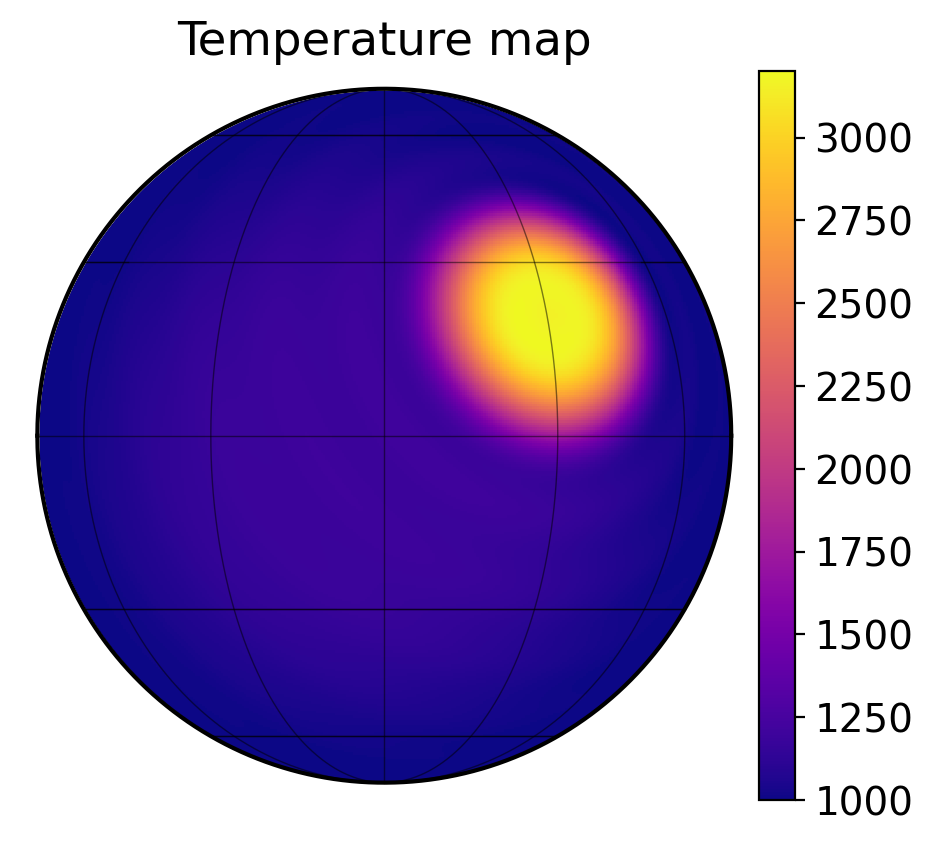

In [10]:
map = starry.Map(30)
fig, ax = plt.subplots(figsize=(5, 5))
map.show(
    image=teff_map, colorbar=True, ax=ax, norm=colors.Normalize(vmin=1000, vmax=3200)
)
ax.set_title("Temperature map")

In [8]:
# Star map
map_star = starry.Map(ydeg=1, nw=Nlam)
Llam = (
    np.pi * (4 * np.pi) * planck(params_s['T'].value, lam)
)  # Integrate Planck function over solid angle and area
map_star.amp = (
    Llam / 4
)  #  Factor of 4 is here because in Starry the luminosity of a featureless map is 4.

# We need to scale the map ampltidues by R^2 to get fluxes in physical units
Rs = params_s["r"].to(u.m).value
Rp = params_p["r"].to(u.m).value
map_star.amp *= Rs ** 2
map_planet.amp *= Rp ** 2

Pre-computing some matrices... Done.


# Generate simulated JWST light curve

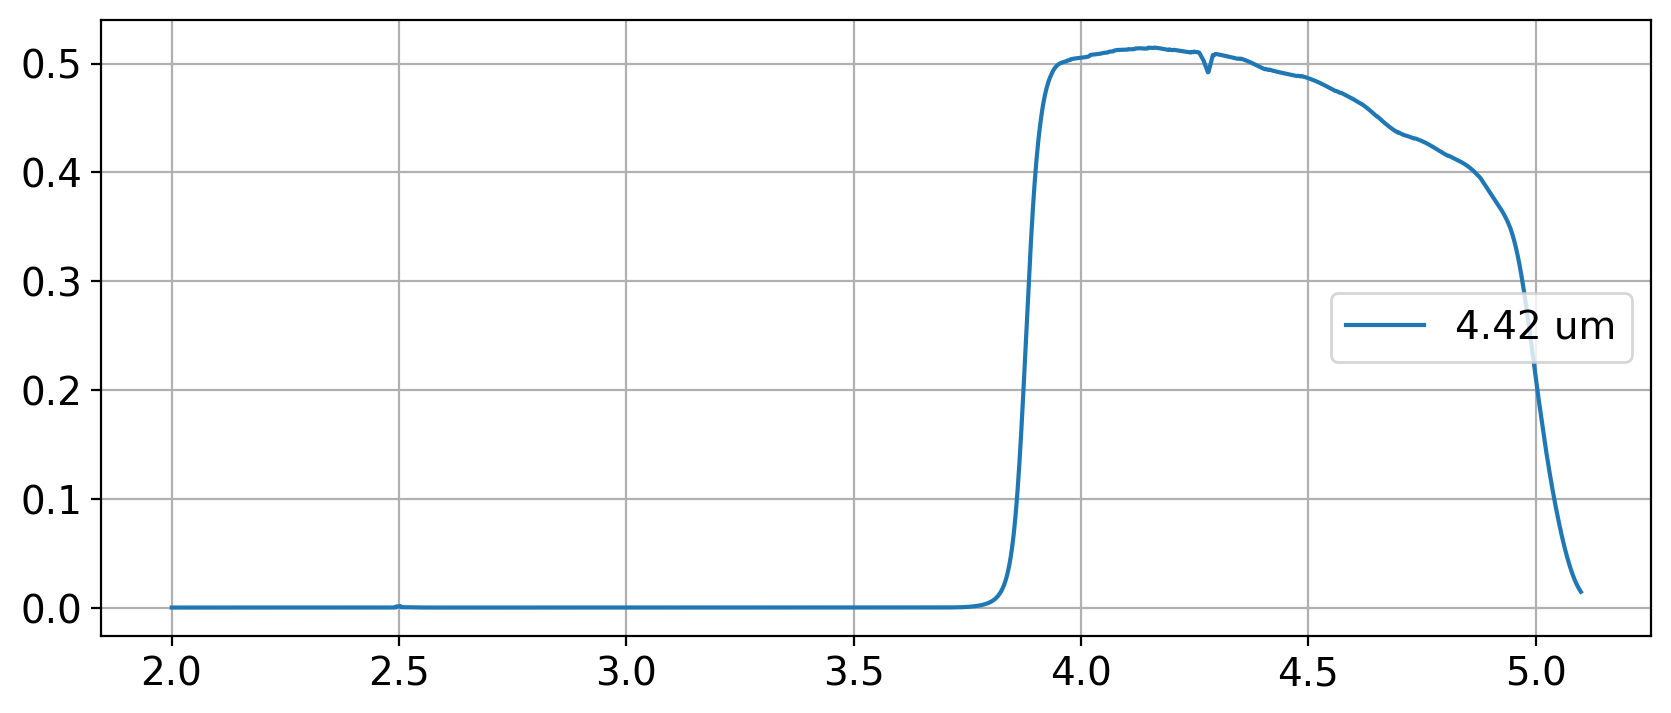

In [9]:
nircam_filters = jwst.get_nircam_filter_wheel()
miri_filters = jwst.get_miri_filter_wheel()

fig, ax = plt.subplots(figsize=(10, 4))
for fil in nircam_filters:
    ax.plot(fil.wl, fil.throughput, label=f"{fil.eff_wl:.2f} um")
    
ax.grid()
ax.legend(loc="right")
# ax.set_xlim(left=4.0)

(<Figure size 1100x700 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9008240d60>)

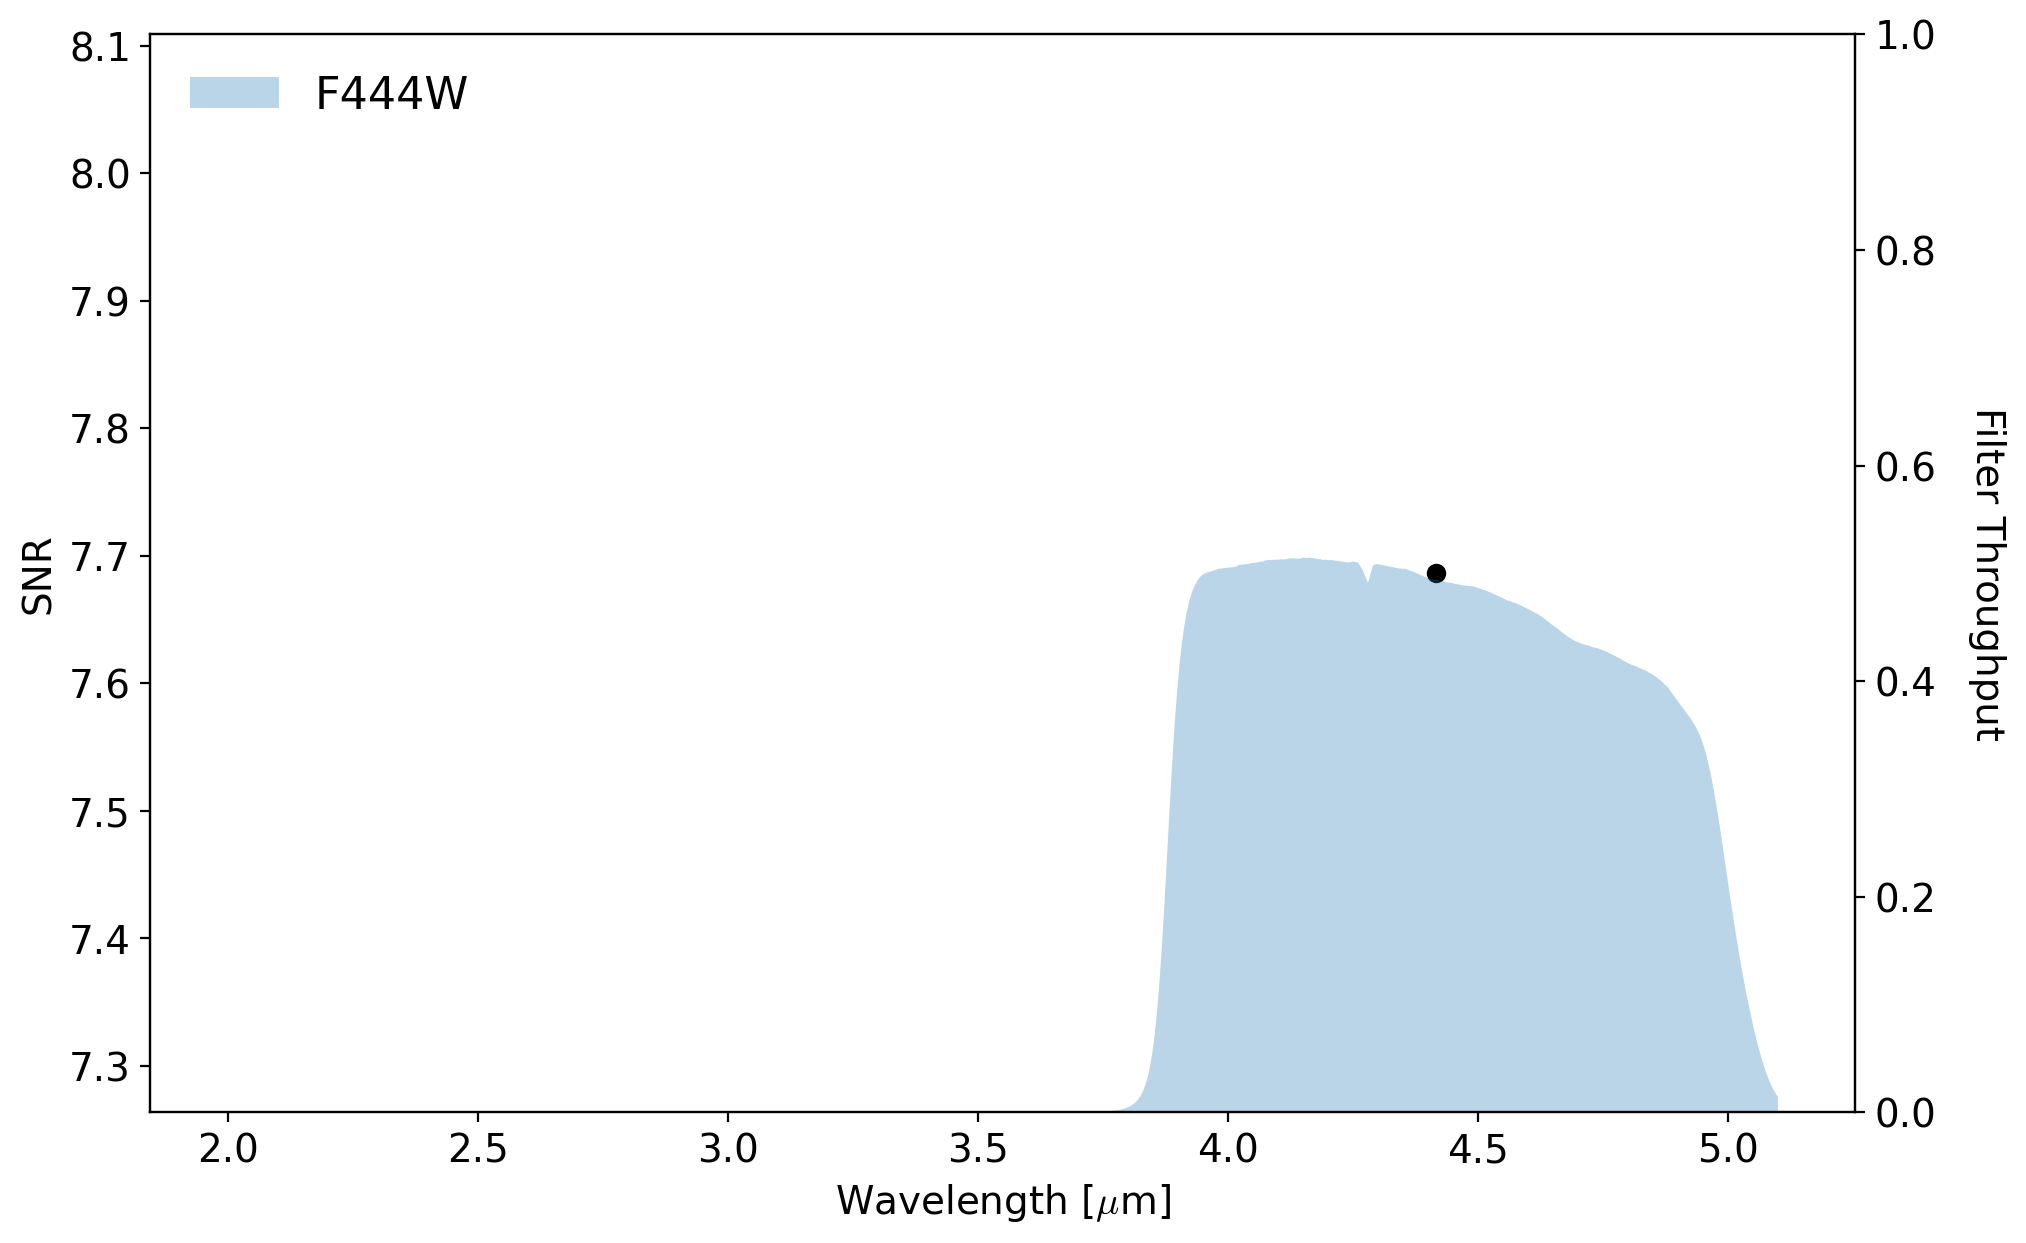

In [10]:
tint = 30 # Integration time in seconds
jwst.estimate_eclipse_snr(
    Tstar=params_s["T"].value, 
    Tplan=2350, Rs=params_s['r'].value, 
    Rp=params_p['r'].to(u.Rearth).value, 
    d=params_s['d'].value, 
    tint=tint,
    filters="NIRCAM",
    verbose=False
 )

(<Figure size 1100x700 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f90084a2d90>)

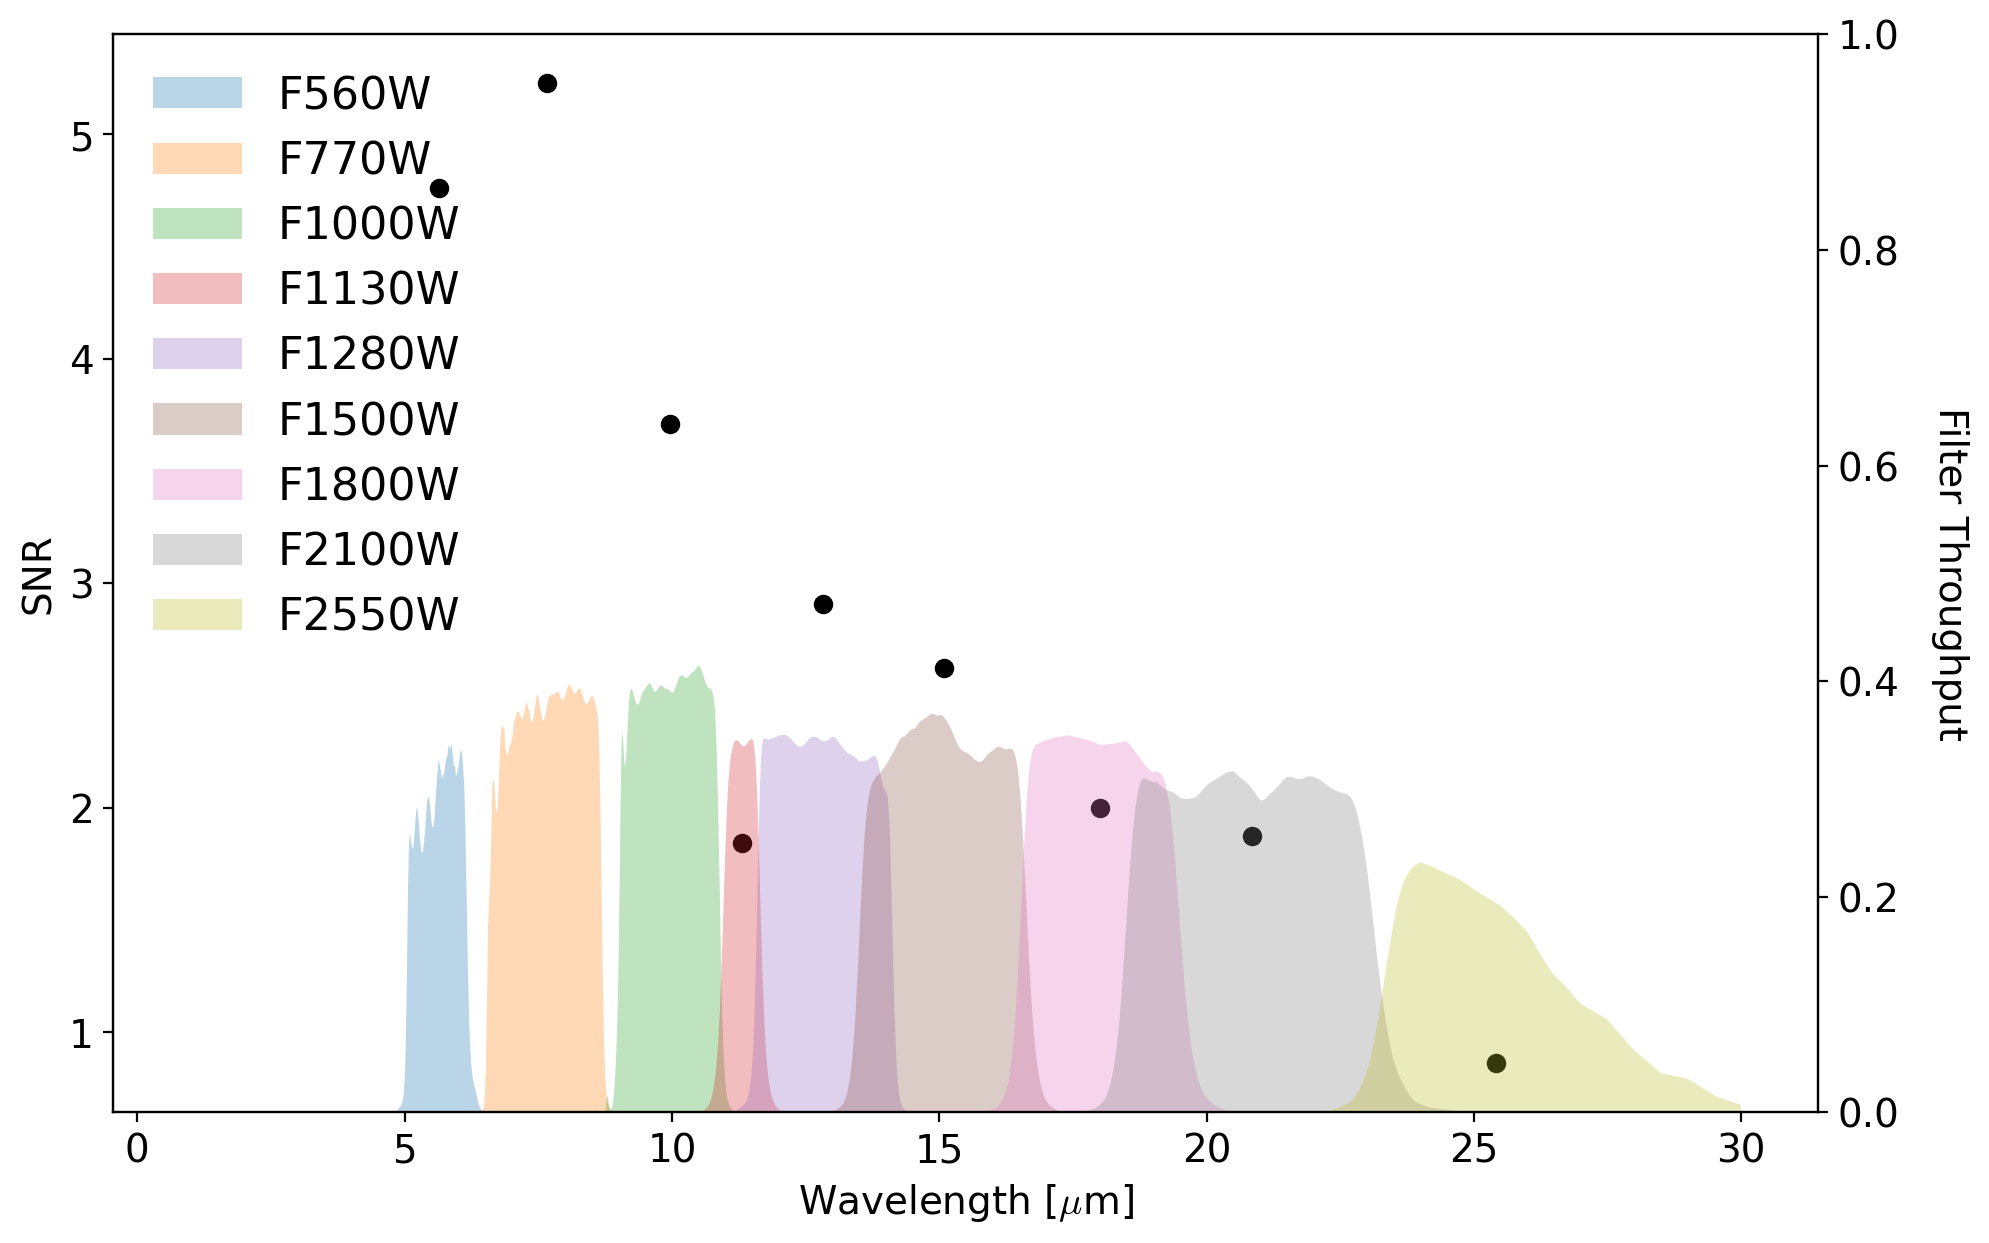

In [11]:
tint = 30 # Integration time in seconds
jwst.estimate_eclipse_snr(
    Tstar=params_s["T"].value, 
    Tplan=2350, Rs=params_s['r'].value, 
    Rp=params_p['r'].to(u.Rearth).value, 
    d=params_s['d'].value, 
    tint=tint,
    verbose=False
 )

In [12]:
def generate_mock_jwst_lc(
    t, filt, texp, params_s, params_p, map_star, map_planet, 
):
    """
    Simulate JWST observation of a system given maps for the star and the planet and the exposure time.
    """
    star = starry.Primary(
        starry.Map(
            ydeg=map_star.ydeg,
            nw=map_star.nw,
            #             udeg=map_star.udeg,
            amp=map_star.amp,
        ),
        r=params_s["r"],
        m=params_s["m"],
        prot=params_s["prot"],
    )

    planet = starry.Secondary(
        starry.Map(
            ydeg=map_planet.ydeg,
            nw=map_planet.nw,
            inc=params_p["inc"],
            amp=map_planet.amp,
        ),
        r=params_p["r"],
        m=params_p["m"],
        porb=params_p["porb"],
        prot=params_p["prot"],
        t0=params_p["t0"],
        inc=params_p["inc"],
    )

    # This is just to compute the continuum flux
    planet_cont = starry.Secondary(
        starry.Map(
            ydeg=map_planet.ydeg,
            nw=map_planet.nw,
            inc=params_p["inc"],
            amp=map_planet.amp,
        ),
        r=params_p["r"],
        m=params_p["m"],
        porb=params_p["porb"],
        prot=params_p["prot"],
        t0=params_p["t0"],
        inc=60.0,
    )

    #     star.map[1:] = params_s["u"]  # limb darkening
    star.map[1:, :, :] = map_star[1:, :, :]
    planet.map[1:, :, :] = map_planet[1:, :, :]
    planet_cont.map[1:, :, :] = map_planet[1:, :, :]

    sys = starry.System(star, planet, texp=(texp.to(u.d)).value, oversample=9, order=0)
    sys_cont = starry.System(
        star, planet_cont, texp=(texp.to(u.d)).value, oversample=9, order=0
    )  

    # Compute flux in physical units
    d = params_s["d"]
    flux = sys.flux(t=t) / (np.pi * (d.to(u.m)) ** 2)  #  W/m2/um
    flux_cont = sys_cont.flux(t=t) / (np.pi * (d.to(u.m)) ** 2)  # W/m2/um

    # Compute light curve using the function from planetplanet
    filt.compute_lightcurve(
        t, flux.value, flux_cont.value, lam, texp=(texp.to(u.d)).value
    )

    return filt.lightcurve, flux, sys

# Compute residuals with respect to uniform map

In [13]:
# Residuals between hotspot model and uniform model
# 20 sec cadence
t0 = -0.736539 / 2
delta_t = 0.05

t_ = np.linspace(t0 - delta_t, t0 + delta_t, 10000)

# NIRCAM F444W filter
# filt = miri_filters[1]
filt = nircam_filters[0]

# Exposure time
texp = 30 * u.s

#  Compute spectrum with Starry taking into account the finite integration time
_, flux_lam, sys = generate_mock_jwst_lc(
    t_, filt, texp, params_s, params_p, map_star, map_planet, 
)

# Interpolate filter throughout to HR grid
Thr = np.interp(lam, filt.wl, filt.throughput)

# Convolve with normalized throughput
flux = np.sum(flux_lam * Thr, axis=1) / np.sum(Thr, axis=0)

Pre-computing some matrices... Done.
Pre-computing some matrices... Done.
Pre-computing some matrices... Done.
Compiling `X`... Done.
Compiling `X`... Done.


Computing observed light curve in F444W filter...


In [14]:
# Compute flux for a uniform map
sys.bodies[1].map.amp = sys.bodies[1].map.flux(theta=180.0)
sys.bodies[1].map[1:, :, :] = np.zeros_like(sys.bodies[1].map[1:, :, :])

flux_lam_unif = sys.flux(t_) / (np.pi * (params_s["d"].to(u.m)) ** 2)
flux_unif = np.sum(flux_lam_unif * Thr, axis=1) / np.sum(Thr, axis=0)

# Normalize and convert to parts-per-million scale
norm = np.min(flux_unif) # Fstar
flux_unif_norm = (flux_unif / norm - 1) * 1e06
flux_norm = (flux / norm - 1) * 1e06
res = flux_norm - flux_unif_norm

Compiling `flux`... Done.


Text(0, 0.5, 'Res. [ppm]')

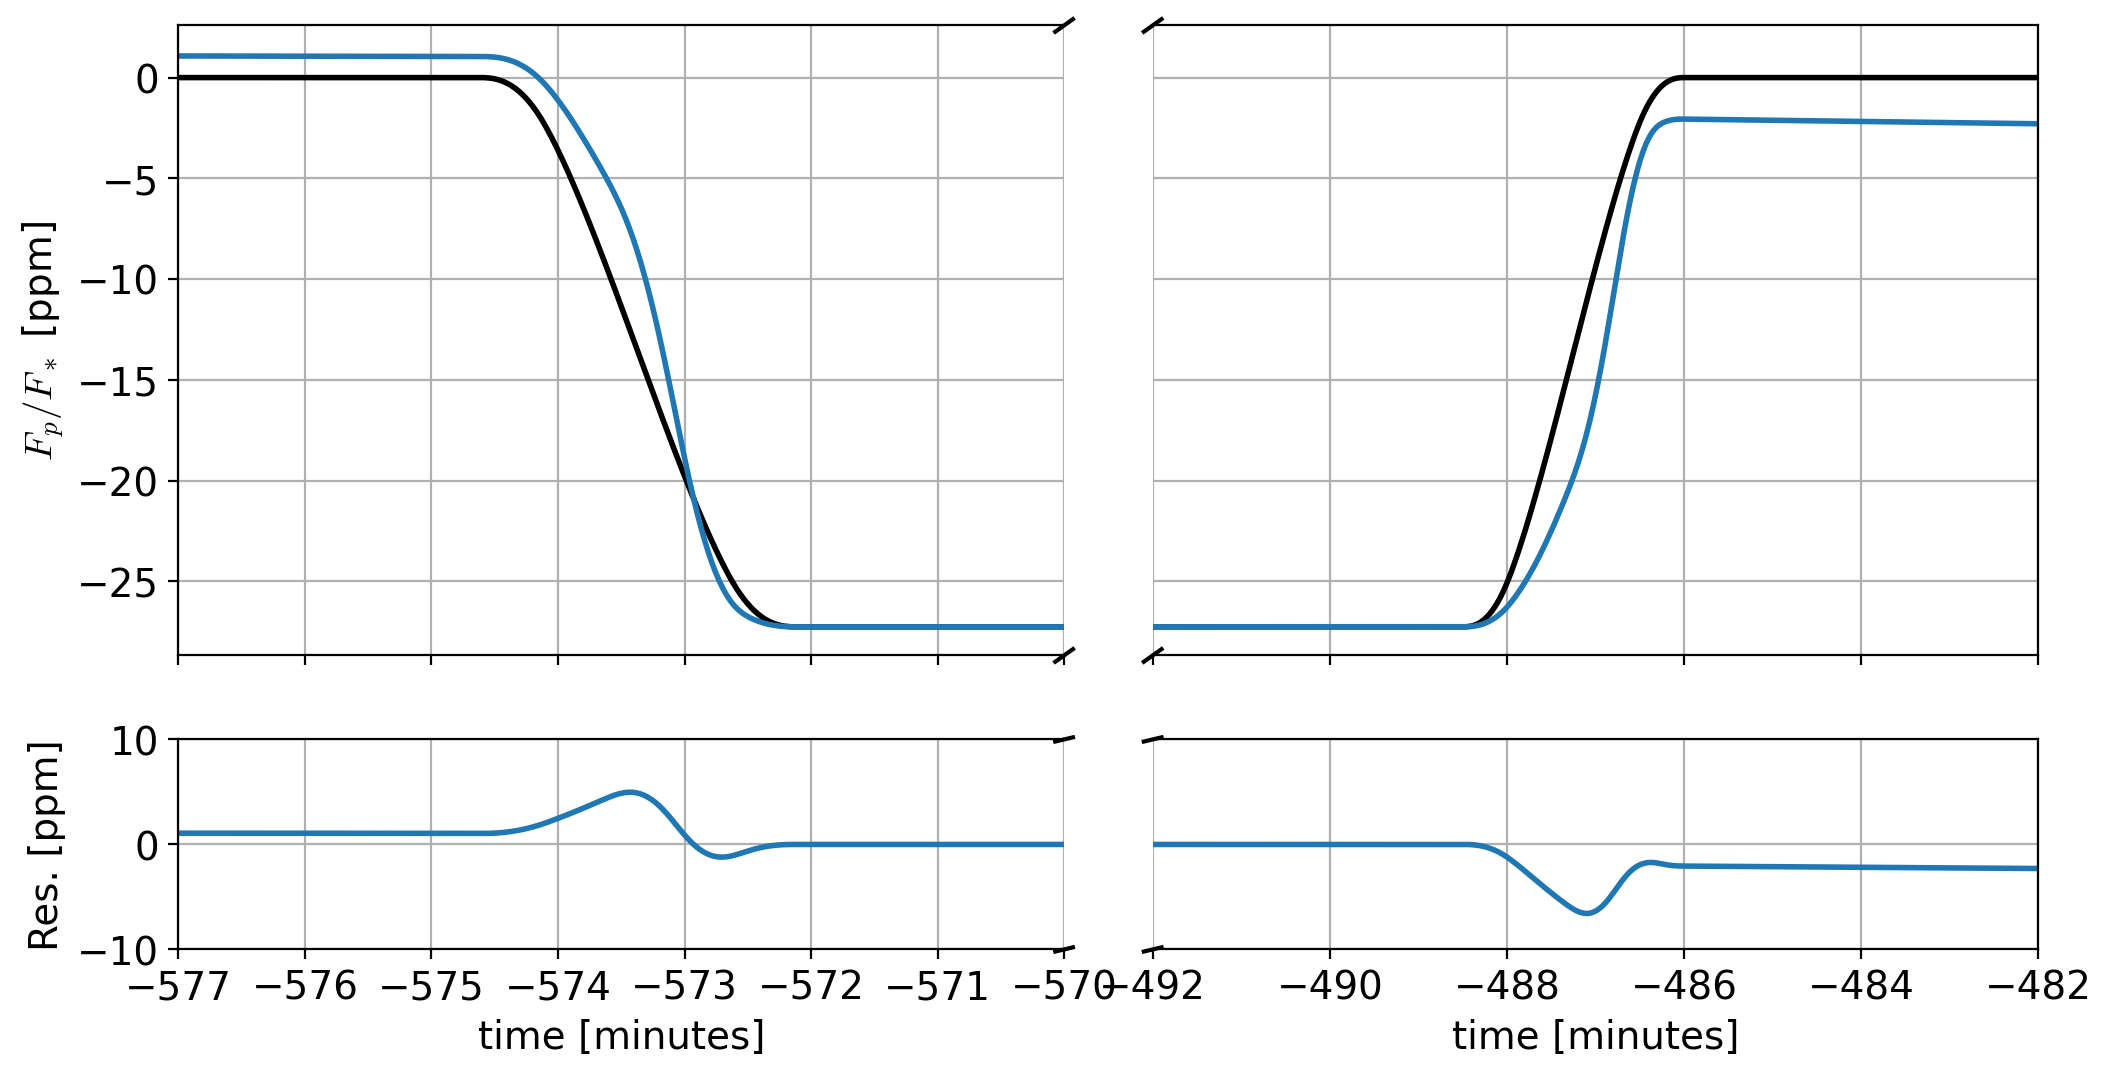

In [15]:
fig, ax = plt.subplots(
    2, 2, figsize=(12, 6), gridspec_kw={"wspace": 0.1, "height_ratios": [3, 1]}
)

for a in ax[0, :]:
    a.plot(t_ * 24 * 60, flux_unif_norm - np.max(flux_unif_norm), "k-", lw=2.0)
    a.plot(t_ * 24 * 60, flux_norm - np.max(flux_unif_norm), "C0-", lw=2.0)

for a in ax[1, :]:
    a.plot(t_ * 24 * 60.0, res, color="C0", lw=2.0)

# Make broken axis
for a in ax:
    a[0].spines["right"].set_visible(False)
    a[1].spines["left"].set_visible(False)
    a[1].tick_params(axis="y", colors=(0, 0, 0, 0))

    d = 0.01
    kwargs = dict(transform=a[0].transAxes, color="k", clip_on=False)
    a[0].plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)
    a[0].plot((1 - d, 1 + d), (-d, +d), **kwargs)

    kwargs.update(transform=a[1].transAxes)
    a[1].plot((-d, +d), (1 - d, 1 + d), **kwargs)
    a[1].plot((-d, +d), (-d, +d), **kwargs)

for a in ax[0, :]:
    a.xaxis.set_ticklabels([])

for a in ax[:, 0].flatten():
    a.set_xlim(-577, -570)

for a in ax[:, 1].flatten():
    a.set_xlim(-492, -482)

for a in ax[1, :]:
    a.set_xlabel("time [minutes]")
    a.set_yticks([-10, 0, 10])

for a in ax.flatten():
    a.grid()

ax[0, 0].set_ylabel(r"$F_p/F_*$ [ppm]")
ax[1, 0].set_ylabel("Res. [ppm]")

## Simulate semi-realistic light curve

In [16]:
t0 = -0.736539 / 2
delta_t = 0.05*u.d # days

# Exposure time
texp = 50 * u.s 

nobs = 5  # Number of observations
npts = (
    int((2 * delta_t.to(u.s)) / texp) * nobs
)  # total number of data points
t = np.linspace(t0 - delta_t.value, t0 + delta_t.value, npts)

lc, flux, sys = generate_mock_jwst_lc(
    t, filt, texp, params_s, params_p, map_star, map_planet, 
)

Pre-computing some matrices... Done.
Pre-computing some matrices... Done.
Pre-computing some matrices... Done.
Compiling `X`... Done.
Compiling `X`... Done.


Computing observed light curve in F444W filter...


Text(0, 0.5, 'Flux [ppm]')

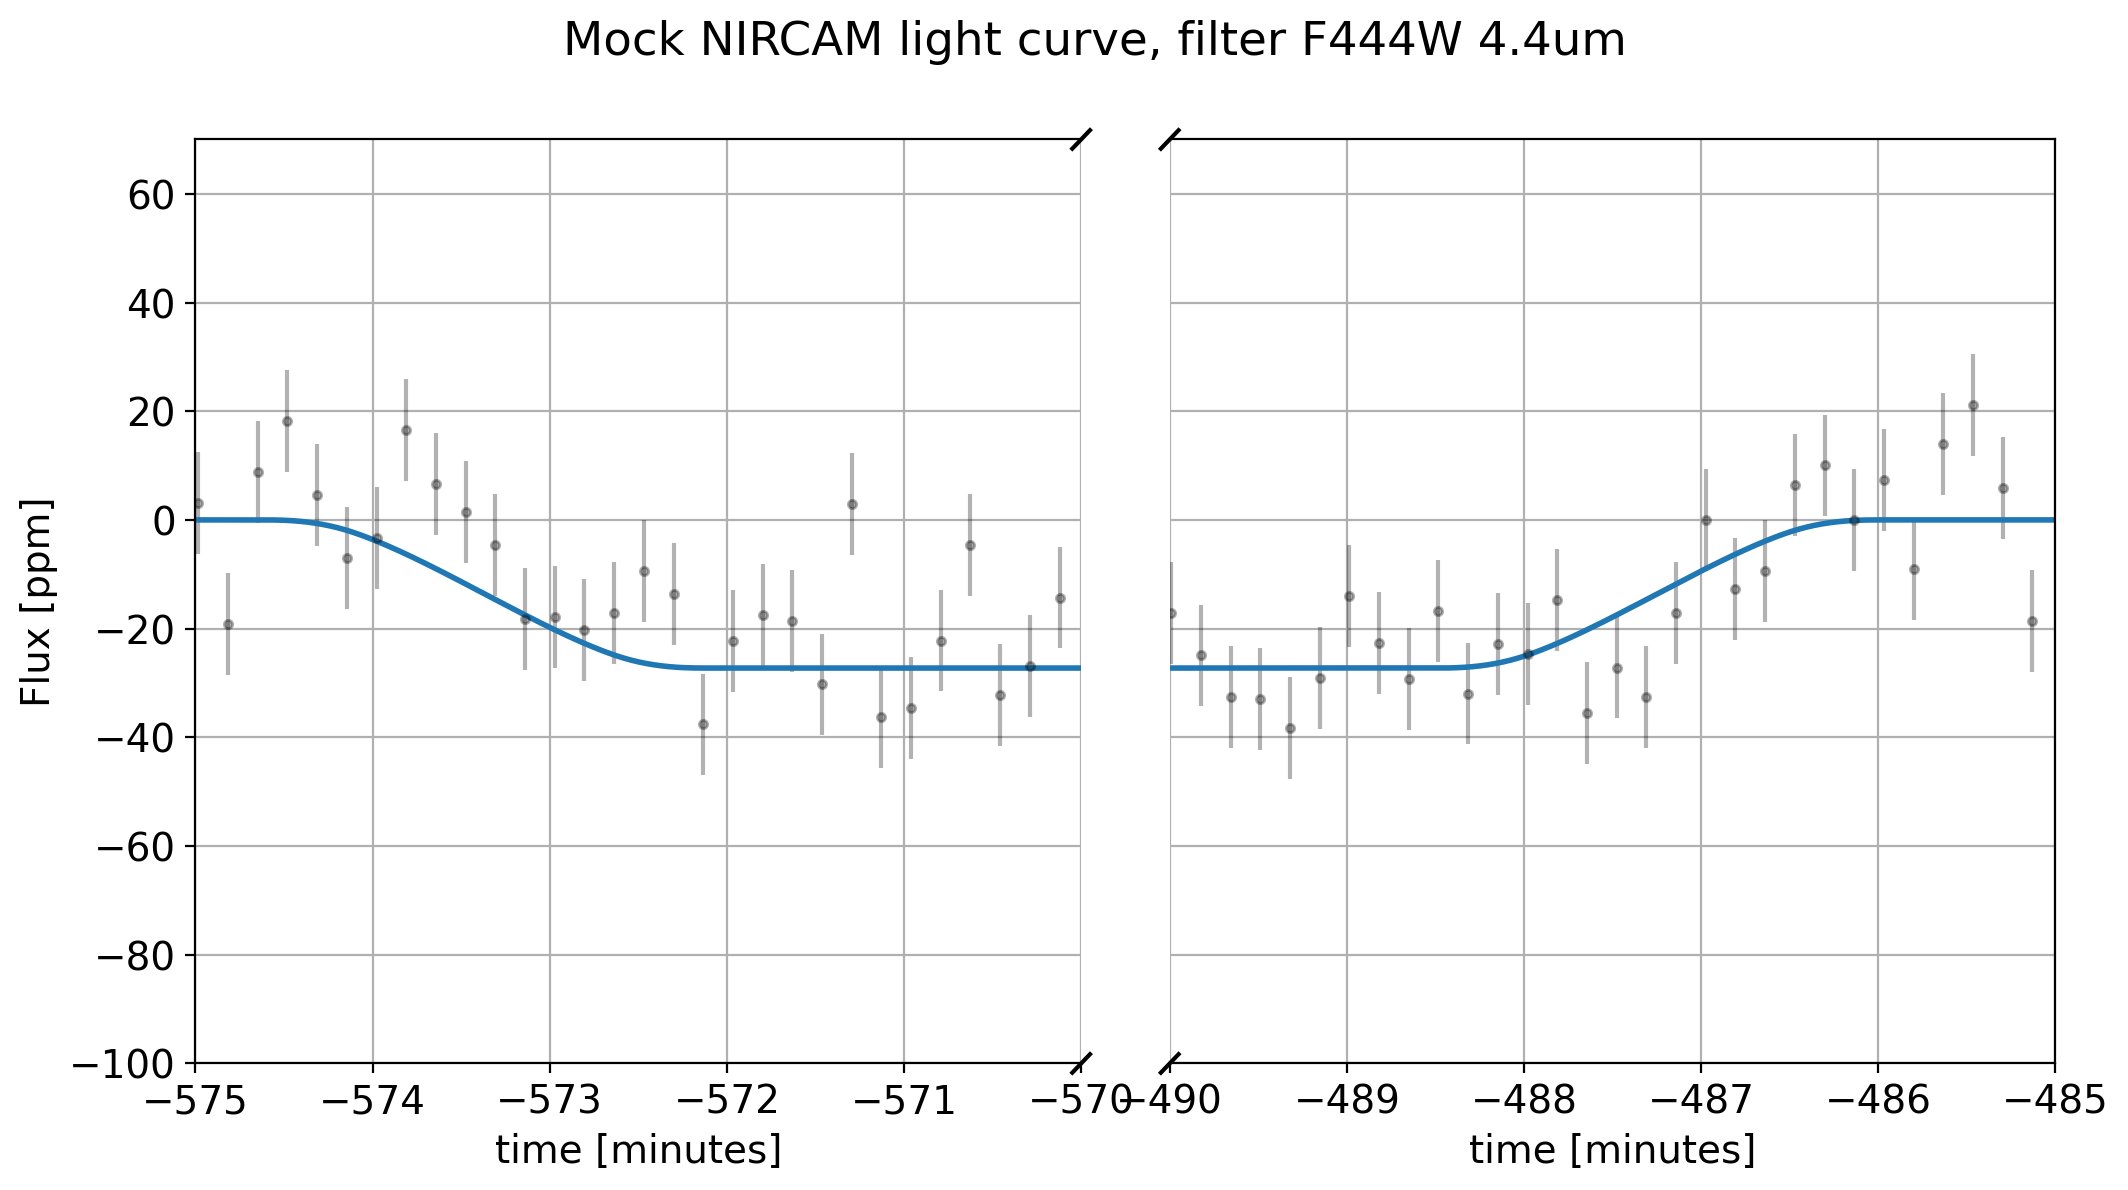

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={"wspace": 0.1})

norm = np.median(lc.obs[:10])
ax[0].errorbar(
    lc.time * 24 * 60,
    (lc.obs / norm - 1) * 1e06 ,
    lc.sig * 1e06,
    marker=".",
    linestyle="",
    color="black",
    alpha=0.3,
)
ax[1].errorbar(
    lc.time * 24 * 60,
    (lc.obs / norm - 1) * 1e06 ,
    lc.sig * 1e06,
    marker=".",
    linestyle="",
    color="black",
    alpha=0.3,
)

ax[0].set_xlim(-575, -570)
ax[1].set_xlim(-490, -485)


fig.suptitle(f"Mock NIRCAM light curve, filter {filt.name} {filt.eff_wl:.1f}um")
# ax.set_xlim(-7.5, 7.5)

for a in ax.flatten():
    a.set_xlabel("time [minutes]")
    a.grid()
    a.set_ylim(-100, 70)

# Make broken axis
ax[0].spines["right"].set_visible(False)
ax[1].spines["left"].set_visible(False)
ax[1].tick_params(axis="y", colors=(0, 0, 0, 0))

d = 0.01
kwargs = dict(transform=ax[0].transAxes, color="k", clip_on=False)
ax[0].plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)
ax[0].plot((1 - d, 1 + d), (-d, +d), **kwargs)

kwargs.update(transform=ax[1].transAxes)
ax[1].plot((-d, +d), (1 - d, 1 + d), **kwargs)
ax[1].plot((-d, +d), (-d, +d), **kwargs)

for a in ax[:]:
    a.plot(t_ * 24 * 60, flux_unif_norm - np.max(flux_unif_norm), "C0-", lw=2.0)
ax[0].set_ylabel("Flux [ppm]")

In [18]:
signal = np.max(flux_norm) - np.min(flux_norm)
signal / (lc.sig[0] * 1e06)

<Quantity 3.03214954>

In [19]:
metadata = {"texp": texp}

#  Save to file
with open("super_earth_lc.pkl", "wb") as handle:
    pkl.dump(lc, handle)
with open("super_earth_star_params.pkl", "wb") as handle:
    pkl.dump(params_s, handle)
with open("super_earth_planet_params.pkl", "wb") as handle:
    pkl.dump(params_p, handle)
with open("super_earth_metadata.pkl", "wb") as handle:
    pkl.dump(metadata, handle)